# Preparation of dataset with Custom annotations

---

The Custom annotations of Coronal Holes and Active Regions were made by trained students of Technical University of Košice using https://www.zooniverse.org crowdsourcing platform.

The attached zip files `ar_custom.zip` and `ch_custom.zip` contain:
- 537 annotations of coronal holes
- 533 annotations of active regions

In [1]:
import sys, os
sys.path.append('../src')

* Import libraries

In [2]:
import glob
import re
import zipfile
from datetime import datetime
from pathlib import Path

import astropy.units as u
import numpy as np
import sunpy
from PIL import Image, ImageDraw
from sunpy.coordinates.sun import angular_radius
from sunpy.net.helioviewer import HelioviewerClient
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import create_contours
from prep_utils import create_labels_img, create_limb_mask, crop_limb

* Define function for parsing files

In [3]:
def parse_coords(text_file):
    with open(text_file) as file:
        lines = file.readlines()
        file.close()
    events = []
    event_coords = []
    date = None
    radius = None
    for i_line, line in enumerate(lines):
        if line.find("DATE") == 0:
            date = line.split("DATE:")[-1].strip()
        elif line.find("RADIUS") == 0:
            radius = float(line.split(":")[-1].strip())
        else:
            # Check if new event coord list starts
            if line.find("CH") == 0 or line.find("AR") == 0:
                if len(event_coords) != 0:
                    events.append(event_coords)
                    event_coords = []
            else:
                line = re.split(r"\s{2,}", line)
                line = [float(s.strip()) for s in line if s != ""]
                event_coords.append(tuple(line))
    # Add last event coords
    events.append(event_coords)
    return date, radius, events

## Coronal Holes

* Unzip Custom annotations for CH

In [4]:
with zipfile.ZipFile("../data/ch_custom.zip","r") as zip_ref:
    zip_ref.extractall("../data/")

* Download SDO / AIA 193 images for date and time of annotations

In [5]:
dir_path = "../data/193(custom)/"
coord_files = glob.glob("../data/ch_custom/*.txt")
# Create required folders
Path(dir_path + "/masks/").mkdir(parents=True, exist_ok=True)

hv = HelioviewerClient()
for file in tqdm(coord_files[:10]):  # Note: Change this if you want to loop over all images not only 10
    name, radius, coords = parse_coords(file)
    date = datetime.strptime(name, '%Y-%m-%d %H:%M:%S.%f')
    # Download SDO/AIA image via Helioviewe API
    fname = hv.download_png(date.strftime("%Y/%m/%d %H:%M:%S"), 2.4, "[SDO,AIA,AIA,193,1,100]",
                            x0=0, y0=0, width=1024, height=1024, progress=False,
                            directory=f"{dir_path}/imgs/")
    fname = fname.split("/")[-1]
    # NOTE: Coords are made for image size of 4096x4096
    blank_img = Image.new("RGB", (4096, 4096), (0, 0, 0))
    img = ImageDraw.Draw(blank_img)
    for annotation in coords:
        try:
            img.polygon(annotation, fill=(255, 255, 255))
        except TypeError:
            pass
    blank_img.resize((1024, 1024)).save(dir_path + "/masks/" + fname)

100%|██████████| 10/10 [00:35<00:00,  3.52s/it]


* Display the downloaded image with the contours from Custom annotation

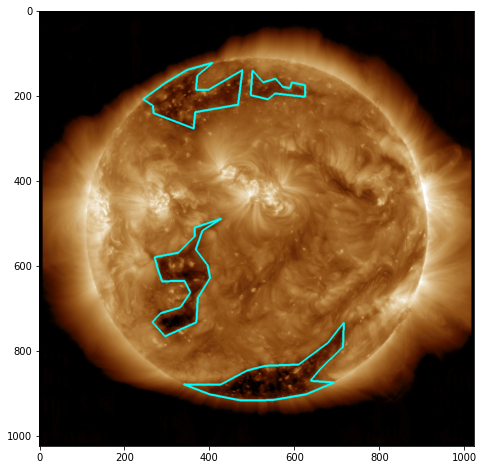

In [6]:
# Load image and mask
img = glob.glob(f"{dir_path}/imgs/*.png")[3]
mask = glob.glob(f"{dir_path}/masks/*.png")[3]
img = Image.open(img).convert("RGB").resize((1024, 1024))
mask = Image.open(mask).convert("L").resize((1024, 1024))

# Draw contours onto image to check it match with image
coords = create_contours(mask, target_size=(1024, 1024))
img_draw = ImageDraw.Draw(img)
for annotation in coords:
    img_draw.line(annotation, fill="cyan", width=5)
plt.figure(figsize = (8,8))
plt.imshow(np.asarray(img))

* Crop limb and save as a new image

In [7]:
create_limb_mask(img_size=(1024, 1024), radius=404, name=dir_path + "limb_mask.png")

imgs = glob.glob(f"{dir_path}/imgs/*.png")
limb = Image.open(dir_path + "limb_mask.png").convert("RGB")
Path(dir_path + "/imgs_prep/").mkdir(parents=True, exist_ok=True)

for img in tqdm(imgs):
    fname = img.split("/")[-1]
    img = Image.open(img).convert("RGB")
    cropped = crop_limb(img, limb)
    cropped.save(f"{dir_path}/imgs_prep/{fname}")

100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


## Active regions


* Unzip Custom annotations for AR

In [8]:
with zipfile.ZipFile("../data/ar_custom.zip","r") as zip_ref:
    zip_ref.extractall("../data/")

* Download SDO / AIA 171 images for date and time of annotations

In [9]:
dir_path = "../data/171(custom)/"
coord_files = glob.glob("../data/ar_custom/*.txt")
# Create required folders
Path(dir_path + "/masks/").mkdir(parents=True, exist_ok=True)

hv = HelioviewerClient()
for file in tqdm(coord_files[:10]):   # Note: Change this if you want to loop over all images not only 10
    name, radius, coords = parse_coords(file)
    date = datetime.strptime(name, '%Y-%m-%d %H:%M:%S.%f')
    # Download SDO/AIA image via Helioviewe API
    fname = hv.download_png(date.strftime("%Y/%m/%d %H:%M:%S"), 2.4, "[SDO,AIA,AIA,171,1,100]",
                            x0=0, y0=0, width=1024, height=1024, progress=False,
                            directory=f"{dir_path}/imgs/")
    fname = fname.split("/")[-1]
    # NOTE: Coords are made for image size of 4096x4096
    blank_img = Image.new("RGB", (4096, 4096), (0, 0, 0))
    img = ImageDraw.Draw(blank_img)
    for annotation in coords:
        try:
            img.polygon(annotation, fill=(255, 255, 255))
        except TypeError:
            pass
    blank_img.resize((1024, 1024)).save(dir_path + "/masks/" + fname)

100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


* Display the downloaded image with the contours from Custom annotation

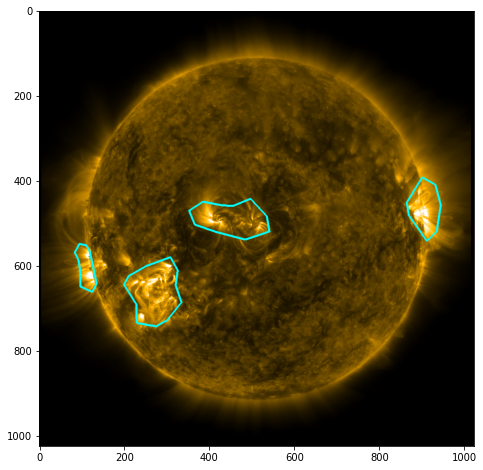

In [10]:
# Load image and mask
img = glob.glob(f"{dir_path}/imgs/*.png")[1]
mask = glob.glob(f"{dir_path}/masks/*.png")[1]
img = Image.open(img).convert("RGB").resize((1024, 1024))
mask = Image.open(mask).convert("L").resize((1024, 1024))

# Draw contours onto images to check it match with image
coords = create_contours(mask, target_size=(1024, 1024))
img_draw = ImageDraw.Draw(img)
for annotation in coords:
    img_draw.line(annotation, fill="cyan", width=5)
plt.figure(figsize = (8,8))
plt.imshow(np.asarray(img))